#### Imports etc

In [1]:
nb_samples = 64
# list_features = ["longitude", "latitude", "groundspeed"] #, "track"] #, "altitude"]
# list_features = ["longitude", "latitude", "track"] #, "track"] #, "altitude"]
list_features = ["longitude", "latitude"]  # , "track"] #, "altitude"]
input_dim = len(list_features)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from traffic.core import Flight, Traffic

from trajectory_clustering.feature_preparation import fit_scaler, prepare_features, traffic_from_features

import wandb
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import numpy as np
import numpy.typing as npt
import pandas as pd
pd.set_option("display.max_columns", None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.autonotebook import tqdm

from scipy.ndimage import gaussian_filter

np.random.seed(0)

torch.manual_seed(0)

# t = Traffic.from_file("./data/resampled_t_near_ap.parquet")
t = Traffic.from_file("./data/2nd_July_15_August/resampled_t_near_ap.parquet")


/var/folders/6r/vdmz5zjj6_d8769grj_ht__80000gn/T/ipykernel_25343/1732798281.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Get features

In [5]:
t

,count
flight_id,
AAL93_19182,64
SWR266V_3204,64
SWR256_15262,64
SWR256_15263,64
SWR256_15264,64
SWR256_15265,64
SWR256_15266,64
SWR256_15267,64
SWR256_15268,64


In [70]:
t_f = t.query("runway_name == '28'")
# t_f = Traffic(t.data.copy())

In [71]:
scaler = fit_scaler(t_f.data[list_features].to_numpy())
X, flight_order = prepare_features(t_f, list_features, scaler)
X = X.reshape(-1, 64, 2).swapaxes(1, 2)


In [9]:
X.shape

(2617, 2, 64)

(-1.0, 1.0)

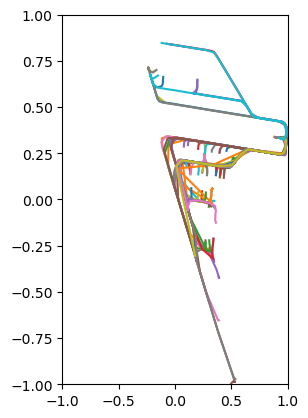

In [72]:
# check that the reshaped X is correct
ax = plt.subplot(1, 2, 1)
for _ in range(100):
    idx = np.random.randint(0, X.shape[0])
    ax.plot(X[idx, 0, :], X[idx, 1, :])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)


In [7]:
def get_flight_image(
    flight_X: npt.NDArray,
    interpolation_precision=512,
    image_height: int = 64,
    max_pixel_value=10,
    min_pixel_value: int | None = None,
) -> npt.NDArray:
    if min_pixel_value is None:
        min_pixel_value = max_pixel_value // 2
        min_pixel_value = min_pixel_value if min_pixel_value > 0 else 1

    image = np.zeros((image_height, image_height))

    interpolation_points = np.linspace(0, image_height, interpolation_precision + 1)[:-1]

    n_points = flight_X.shape[-1]

    interp_x = np.interp(interpolation_points, np.linspace(0, image_height, n_points + 1)[:-1], flight_X[0])
    interp_y = np.interp(interpolation_points, np.linspace(0, image_height, n_points + 1)[:-1], flight_X[1])

    # print(np.max(interp_x), np.max(interp_y))

    for i in range(interpolation_precision):
        x_pixel = int(interp_x[i])
        y_pixel = int(interp_y[i])

        if image[y_pixel, x_pixel] == 0:
            image[y_pixel, x_pixel] = min_pixel_value
        elif image[y_pixel, x_pixel] < max_pixel_value:
            image[y_pixel, x_pixel] += 1

    return image

In [8]:
def get_images(
    X: npt.NDArray,
    interpolation_precision=512,
    image_height: int = 64,
    gaussian_filter_sigma: float = 0.0,
    max_pixel_value=10,
    min_pixel_value: int | None = None,
) -> list[npt.NDArray]:
    """
    Get list of matrix images from X. To be used with matplotlib.pyplot.imshow() with origin='lower' (lower left)

    X should be a 3D array of shape (n_samples, 2, n_points) corresponding to ["longitude", "latitude"] coordinates, scaled between -1 and 1

    Output will be a 4D array of shape (n_samples, 1, image_height, image_height) corresponding to the images of the trajectories, scaled between 0 and 1
    """
    images = []

    X = (X + 1) * ((image_height - 1) / image_height) * image_height / 2

    for i in range(X.shape[0]):
        images.append(
            get_flight_image(
                X[i],
                interpolation_precision=interpolation_precision,
                image_height=image_height,
                max_pixel_value=max_pixel_value,
                min_pixel_value=min_pixel_value,
            )
        )

    if gaussian_filter_sigma > 0:
        images = gaussian_filter(images, sigma=gaussian_filter_sigma, axes=[1, 2])

    images = np.array(images, dtype="float32")
    images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2])
    images = images / max_pixel_value

    return images  # type: ignore

In [73]:
# images = get_images(X, interpolation_precision=2048, image_height=128, gaussian_filter_sigma=0.5)
# images = get_images(X, interpolation_precision=2048, image_height=64, gaussian_filter_sigma=0.5)
images = get_images(X, interpolation_precision=2048, image_height=64, gaussian_filter_sigma=0., max_pixel_value=1)

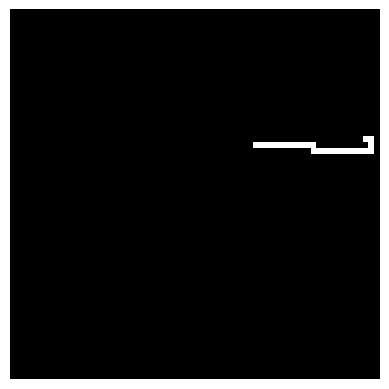

In [74]:
idx = np.random.randint(0, X.shape[0])

# Plot the original trajectory
# # flight = t_f[flight_order[idx]]
# plt.plot(X[idx, 0, :], X[idx, 1, :], 'k')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.axis('off')
# plt.show()

# Plot the image
image = images[idx][0]

plt.imshow(image, cmap='gray', origin="lower")
plt.axis('off')
plt.show()

#### Convolutional Autoencoder

In [433]:
class Convolutional2d_AE(nn.Module):
    def __init__(
        self,
        channels: int = 1,
        relu: nn.Module = nn.ReLU(),
        latent_dim: int = 2,
        image_size: int = 64,
        dropout: float = 0,
    ):
        super(Convolutional2d_AE, self).__init__()

        self.relu = relu
        self.kernel_size = 3
        # self.normal_dist = torch.distributions.Normal(0, 1)
        self.normal_dist = torch.distributions.Normal(0, 1)

        if dropout > 0:
            self.drop_out = nn.Dropout(dropout)
            self.conv_drop_out = nn.Dropout2d(dropout)
        else:
            self.drop_out = nn.Identity()
            self.conv_drop_out = nn.Identity()

        self.encoder = nn.Sequential(
            # input: 1, image_size, image_size
            nn.Conv2d(channels, 16, kernel_size=self.kernel_size, stride=2, padding=1),
            self.conv_drop_out,
            # 16, image_size/2, image_size/2
            # nn.BatchNorm2d(16),
            self.relu,
            nn.Conv2d(16, 32, kernel_size=self.kernel_size, stride=2, padding=1),
            self.conv_drop_out,
            # 32, image_size/4, image_size/4
            # nn.BatchNorm2d(32),
            self.relu,
            nn.Conv2d(32, 64, kernel_size=self.kernel_size, stride=2, padding=1),
            self.conv_drop_out,
            # 64, image_size/8, image_size/8
            # nn.BatchNorm2d(64),
            self.relu,
        )

        # self.encoder_linear = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)
        # self.encoder_sigma = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)
        self.linear_step = nn.Sequential(
            nn.Linear(64 * (image_size // 8) * (image_size // 8), 32 * (image_size // 8) * (image_size // 8)),
            self.drop_out,
            self.relu,
            nn.Linear(32 * (image_size // 8) * (image_size // 8), 16 * (image_size // 8) * (image_size // 8)),
            self.drop_out,
            self.relu,
            nn.Linear(16 * (image_size // 8) * (image_size // 8), 8),
            self.drop_out,
            self.relu,
        )

        self.encoder_linear = nn.Linear(8, latent_dim)
        # self.encoder_sigma = nn.Sequential(
        #     nn.Linear(8, latent_dim),
        #     # nn.Softplus(),/
        #     nn.LeakyReLU(),
        # )

        # self.decoder_linear = nn.Linear(latent_dim, 64 * (image_size // 8) * (image_size // 8))
        self.decoder_linear = nn.Sequential(
            nn.Linear(latent_dim, 8),
            self.drop_out,
            self.relu,
            nn.Linear(8, 16 * (image_size // 8) * (image_size // 8)),
            self.drop_out,
            self.relu,
            nn.Linear(16 * (image_size // 8) * (image_size // 8), 32 * (image_size // 8) * (image_size // 8)),
            self.drop_out,
            self.relu,
            nn.Linear(32 * (image_size // 8) * (image_size // 8), 64 * (image_size // 8) * (image_size // 8)),
            self.drop_out,
            self.relu,
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            self.conv_drop_out,
            # 32, image_size/4, image_size/4
            # nn.BatchNorm2d(32),
            self.relu,
            nn.ConvTranspose2d(32, 16, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            self.conv_drop_out,
            # 16, image_size/2, image_size/2
            # nn.BatchNorm2d(16),
            self.relu,
            nn.ConvTranspose2d(16, channels, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            self.conv_drop_out,
            # channels, image_size, image_size
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        encoded_shape = x.shape
        # x = x.view(x.size(0), -1)
        # mu = self.encoder_linear(x)
        # # mu = nn.Tanh()(mu)
        # sigma = torch.exp(self.encoder_sigma(x))
        # # x = nn.Tanh()(mu)
        # # x = mu.clone()
        # # x = 6 * x
        # # x = mu

        x = self.linear_step(x.view(x.size(0), -1))
        # encoded_shape = x.shape
        mu = self.encoder_linear(x)
        # sigma = torch.exp(self.encoder_sigma(x))

        # self.latent = x.clone()
        self.latent = mu.clone()

        self.latent_abs_mean = torch.abs(mu).mean()

        # x = mu + sigma * self.normal_dist.sample(mu.shape).to(x.device)
        x = mu + self.normal_dist.sample(mu.shape).to(x.device)
        self.noisy_latent = x.clone()

        # self.kl = (mu**2 + sigma**2 - torch.log(sigma) - 0.5).sum() / x.shape[0]
        self.kl = (mu**2 + 1 - 0.5).sum() / x.shape[0]

        x = self.decoder_linear(x)
        x = x.view(x.size(0), 64, encoded_shape[2], encoded_shape[3])
        x = self.decoder(x)
        return x

In [17]:
cae = Convolutional2d_AE()

In [75]:
X_images = images
Y_images = cae(torch.tensor(X_images, dtype=torch.float32)).detach().numpy()

In [76]:
class Convolutional2d_AE(nn.Module):
    def __init__(
        self,
        channels: int = 1,
        relu: nn.Module = nn.ReLU(),
        latent_dim: int = 2,
        image_size: int = 64,
        dropout: float = 0,
    ):
        super(Convolutional2d_AE, self).__init__()

        self.relu = relu
        self.kernel_size = 3
        # self.normal_dist = torch.distributions.Normal(0, 1)
        self.normal_dist = torch.distributions.Normal(0, 0.3)

        if dropout > 0:
            self.drop_out = nn.Dropout(dropout)
            # self.conv_drop_out = nn.Dropout2d(dropout)
            self.conv_drop_out = nn.Identity()
        else:
            self.drop_out = nn.Identity()
            self.conv_drop_out = nn.Identity()

        self.encoder = nn.Sequential(
            # input: 1, image_size, image_size
            nn.Conv2d(channels, 16, kernel_size=self.kernel_size, stride=2, padding=1),
            self.conv_drop_out,
            # 16, image_size/2, image_size/2
            # nn.BatchNorm2d(16),
            self.relu,
            nn.Conv2d(16, 32, kernel_size=self.kernel_size, stride=2, padding=1),
            self.conv_drop_out,
            # 32, image_size/4, image_size/4
            # nn.BatchNorm2d(32),
            self.relu,
            nn.Conv2d(32, 64, kernel_size=self.kernel_size, stride=2, padding=1),
            self.conv_drop_out,
            # 64, image_size/8, image_size/8
            # nn.BatchNorm2d(64),
            self.relu,
        )

        # self.encoder_linear = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)
        # self.encoder_sigma = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)
        self.linear_step = nn.Sequential(
            # nn.Linear(64 * (image_size // 8) * (image_size // 8), 32 * (image_size // 8) * (image_size // 8)),
            nn.Linear(64 * (image_size // 8) * (image_size // 8), 16 * (image_size // 8) * (image_size // 8)),
            self.drop_out,
            self.relu,
            # nn.Linear(32 * (image_size // 8) * (image_size // 8), 16 * (image_size // 8) * (image_size // 8)),
            # self.drop_out,
            # self.relu,
            nn.Linear(16 * (image_size // 8) * (image_size // 8), 8),
            self.drop_out,
            self.relu,
        )

        self.encoder_linear = nn.Linear(8, latent_dim)
        # self.encoder_sigma = nn.Sequential(
        #     nn.Linear(8, latent_dim),
        #     # nn.Softplus(),/
        #     nn.LeakyReLU(),
        # )

        # self.decoder_linear = nn.Linear(latent_dim, 64 * (image_size // 8) * (image_size // 8))
        self.decoder_linear = nn.Sequential(
            nn.Linear(latent_dim, 8),
            self.drop_out,
            self.relu,
            nn.Linear(8, 16 * (image_size // 8) * (image_size // 8)),
            self.drop_out,
            self.relu,
            # nn.Linear(16 * (image_size // 8) * (image_size // 8), 32 * (image_size // 8) * (image_size // 8)),
            # self.drop_out,
            # self.relu,
            # nn.Linear(32 * (image_size // 8) * (image_size // 8), 64 * (image_size // 8) * (image_size // 8)),
            nn.Linear(16 * (image_size // 8) * (image_size // 8), 64 * (image_size // 8) * (image_size // 8)),
            self.drop_out,
            self.relu,
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            self.conv_drop_out,
            # 32, image_size/4, image_size/4
            # nn.BatchNorm2d(32),
            self.relu,
            nn.ConvTranspose2d(32, 16, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            self.conv_drop_out,
            # 16, image_size/2, image_size/2
            # nn.BatchNorm2d(16),
            self.relu,
            nn.ConvTranspose2d(16, channels, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            self.conv_drop_out,
            # channels, image_size, image_size
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        encoded_shape = x.shape
        # x = x.view(x.size(0), -1)
        # mu = self.encoder_linear(x)
        # # mu = nn.Tanh()(mu)
        # sigma = torch.exp(self.encoder_sigma(x))
        # # x = nn.Tanh()(mu)
        # # x = mu.clone()
        # # x = 6 * x
        # # x = mu

        x = self.linear_step(x.view(x.size(0), -1))
        # encoded_shape = x.shape
        mu = self.encoder_linear(x)
        # sigma = torch.exp(self.encoder_sigma(x))

        # self.latent = x.clone()
        self.latent = mu.clone()

        self.latent_abs_mean = torch.abs(mu).mean()

        # x = mu + sigma * self.normal_dist.sample(mu.shape).to(x.device)
        # x = mu + self.normal_dist.sample(mu.shape).to(x.device)
        x= mu
        self.noisy_latent = x.clone()

        # self.kl = (mu**2 + sigma**2 - torch.log(sigma) - 0.5).sum() / x.shape[0]
        self.kl = (mu**2 + 1 - 0.5).sum() / x.shape[0]

        x = self.decoder_linear(x)
        x = x.view(x.size(0), 64, encoded_shape[2], encoded_shape[3])
        x = self.decoder(x)
        return x

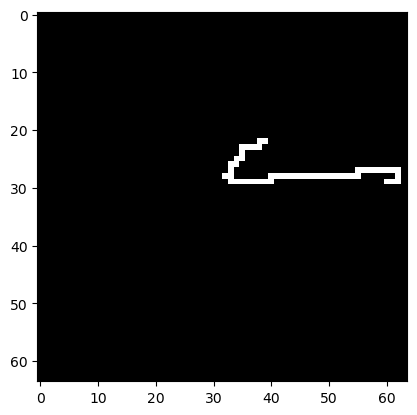

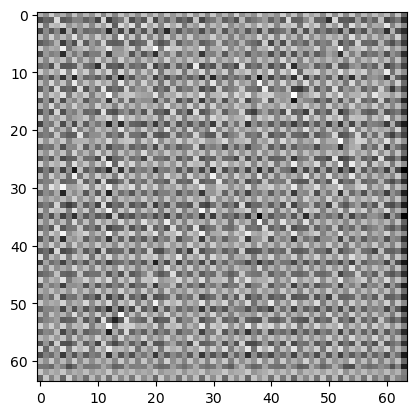

In [17]:
idx = np.random.randint(0, len(X_images))

plt.imshow(X_images[idx].reshape(64, 64), cmap='gray')
plt.show()

plt.imshow(Y_images[idx].reshape(64, 64), cmap='gray')
plt.show()


In [12]:
class Convolutional2d_AE(nn.Module): ## NUL
    def __init__(
        self,
        channels: int = 1,
        relu: nn.Module = nn.ReLU(),
        latent_dim: int = 2,
        image_size: int = 64,
        dropout: float = 0,
    ):
        super(Convolutional2d_AE, self).__init__()

        self.relu = relu
        self.kernel_size = 3
        # self.normal_dist = torch.distributions.Normal(0, 1)

        if dropout > 0:
            self.drop_out = nn.Dropout(dropout)
            # self.conv_drop_out = nn.Dropout2d(dropout)
            self.conv_drop_out = nn.Identity()
        else:
            self.drop_out = nn.Identity()
            self.conv_drop_out = nn.Identity()

        self.encoder = nn.Sequential(
            # input: 1, image_size, image_size
            nn.Conv2d(channels, 16, kernel_size=self.kernel_size, stride=2, padding=1),
            self.conv_drop_out,
            # 16, image_size/2, image_size/2
            # nn.BatchNorm2d(16),
            self.relu,
            nn.Conv2d(16, 32, kernel_size=self.kernel_size, stride=2, padding=1),
            self.conv_drop_out,
            # 32, image_size/4, image_size/4
            # nn.BatchNorm2d(32),
            self.relu,
            nn.Conv2d(32, 64, kernel_size=self.kernel_size, stride=2, padding=1),
            self.conv_drop_out,
            # 64, image_size/8, image_size/8
            # nn.BatchNorm2d(64),
            self.relu,
        )

        # self.encoder_linear = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)
        # self.encoder_sigma = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)
        self.linear_step = nn.Sequential(
            nn.Linear(64 * (image_size // 8) * (image_size // 8), 16 * (image_size // 8) * (image_size // 8)),
            # nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim),
            self.drop_out,
            self.relu,
            nn.Linear(16 * (image_size // 8) * (image_size // 8), 8),
            self.drop_out,
            self.relu,
        )

        self.encoder_linear = nn.Linear(8, latent_dim)
        self.encoder_sigma = nn.Sequential(
            nn.Linear(8, latent_dim),
            # nn.Softplus(),/
            nn.LeakyReLU(),
        )

        # self.decoder_linear = nn.Linear(latent_dim, 64 * (image_size // 8) * (image_size // 8))
        self.decoder_linear = nn.Sequential(
            nn.Linear(latent_dim, 64 * (image_size // 8) * (image_size // 8)),
            self.drop_out,
            self.relu,
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            self.conv_drop_out,
            self.relu,
            nn.ConvTranspose2d(32, 16, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            self.conv_drop_out,
            self.relu,
            nn.ConvTranspose2d(16, channels, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            self.conv_drop_out,
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        encoded_shape = x.shape
        # x = x.view(x.size(0), -1)
        # mu = self.encoder_linear(x)
        # # mu = nn.Tanh()(mu)
        # sigma = torch.exp(self.encoder_sigma(x))
        # # x = nn.Tanh()(mu)
        # # x = mu.clone()
        # # x = 6 * x
        # # x = mu

        x = self.linear_step(x.view(x.size(0), -1))

        self.latent = x.clone()

        self.latent_abs_mean = torch.abs(x).mean()

        self.noisy_latent = x.clone()

        # self.kl = (mu**2 + sigma**2 - torch.log(sigma) - 0.5).sum() / x.shape[0]
        self.kl = (x**2 + 1 - 0.5).sum() / x.shape[0]

        x = self.decoder_linear(x)
        x = x.view(x.size(0), 64, encoded_shape[2], encoded_shape[3])
        x = self.decoder(x)
        return x

In [77]:
def train(
    model: Convolutional2d_AE,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    epochs: int,
    lr: float,
    device: str = "cpu",
    kl_weight: float = 0.05,
    use_kl_loss=False,
):
    model = model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    # criterion = nn.MSELoss()
    criterion = nn.BCELoss(reduction="mean")

    epoch_losses = []
    epoch_val_losses = []
    epoch_bce_losses = []
    epoch_kl_losses = []
    epoch_latent_abs_mean_losses = []

    use_kl = False
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        running_bce_loss = 0.0
        running_kl_loss = 0.0
        running_latent_abs_mean_loss = 0.0

        # use_kl = np.random.rand() < 0.2 and epoch > 5 and epochs - epoch > 5
        # if use_kl:
        #     print("kl used")
        if use_kl_loss:
            use_kl = epoch % 7 == 0 and epoch > 5 and epochs - epoch > 5 and epoch_kl_losses[-1] > 5
        if use_kl:
            print("kl used")

        model.train()
        for data in train_loader:
            # print(data[0].shape)
            # img, _ = data[0]
            img = data[0]
            img = img.to(device)
            optimizer.zero_grad()

            output = model(img)
            loss_bce = criterion(output, img)
            loss_kl = model.kl
            loss_latent_abs_mean = model.latent_abs_mean

            # if use_kl:
            #     # loss = loss_bce/kl_weight + loss_kl * kl_weight / 100
            #     # loss = loss_bce + loss_kl * kl_weight
            #     loss = loss_bce + loss_kl / 1000
            # else:
            #     # loss = loss_bce + loss_latent_abs_mean / 10000

            #     if epoch > 7:
            #         loss = loss_bce + loss_latent_abs_mean / 10000
            #     else:
            #         loss = loss_bce
            loss = loss_bce

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_bce_loss += loss_bce.item()
            running_kl_loss += loss_kl.item()
            running_latent_abs_mean_loss += loss_latent_abs_mean.item()

        print(
            f"epoch: {epoch + 1}, loss: {running_loss / len(train_loader)}, bce: {running_bce_loss / len(train_loader)}, kl: {running_kl_loss / len(train_loader)}, latent_abs_mean: {running_latent_abs_mean_loss / len(train_loader)}"
        )
        epoch_losses.append(running_loss / len(train_loader))
        epoch_bce_losses.append(running_bce_loss / len(train_loader))
        epoch_kl_losses.append(running_kl_loss / len(train_loader))
        epoch_latent_abs_mean_losses.append(running_latent_abs_mean_loss / len(train_loader))


        # validation step
        model.eval()
        
        running_loss = 0.0
        for data in validation_loader:
            # img, _ = data[0]
            img = data[0]
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            running_loss += loss.item()

        print(f"validation loss: {running_loss / len(validation_loader)}")
        epoch_val_losses.append(running_loss / len(validation_loader))

    return model, epoch_losses, epoch_val_losses, epoch_bce_losses

In [78]:
dataset = TensorDataset(torch.tensor(X_images, dtype=torch.float32))

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])


In [79]:
# batch_size = 64
# batch_size = 32
batch_size = 8
# batch_size = 8
# epochs = 25
epochs = 10

workers = 0
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

device = "mps"

model = Convolutional2d_AE(
    relu=nn.LeakyReLU(),
    # dropout=0.3,
    # dropout=0.1,
    dropout=0.,
    # dropout=0.5,
)
# model = Convolutional2d_AE(relu=nn.ReLU())

model, epoch_loss, valid_loss, epoch_bce_loss = train(
    epochs=epochs,
    model=model,
    train_loader=train_loader,
    validation_loader=test_loader,
    device=device,
    # lr=1e-3,
    lr=1e-3,
    # kl_weight=0.01
)


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1, loss: 0.03561961421538949, bce: 0.03561961421538949, kl: 362.67961131716953, latent_abs_mean: 10.463482384144523
validation loss: 0.009550453454003106
epoch: 2, loss: 0.008153879530311067, bce: 0.008153879530311067, kl: 932.7224149821717, latent_abs_mean: 16.99367651085795
validation loss: 0.007453155966855034
epoch: 3, loss: 0.007079532279426025, bce: 0.007079532279426025, kl: 922.8476080246913, latent_abs_mean: 17.62989052725427
validation loss: 0.006859872115051581
epoch: 4, loss: 0.006638128997436092, bce: 0.006638128997436092, kl: 825.992461969823, latent_abs_mean: 16.80178475232772
validation loss: 0.006800145137894117
epoch: 5, loss: 0.006399401454585547, bce: 0.006399401454585547, kl: 699.8915298367724, latent_abs_mean: 15.55004855585687
validation loss: 0.00766762730056121
epoch: 6, loss: 0.006277312481499932, bce: 0.006277312481499932, kl: 640.7836881095981, latent_abs_mean: 15.069902216946637
validation loss: 0.006479283889617633
epoch: 7, loss: 0.00607777951733657

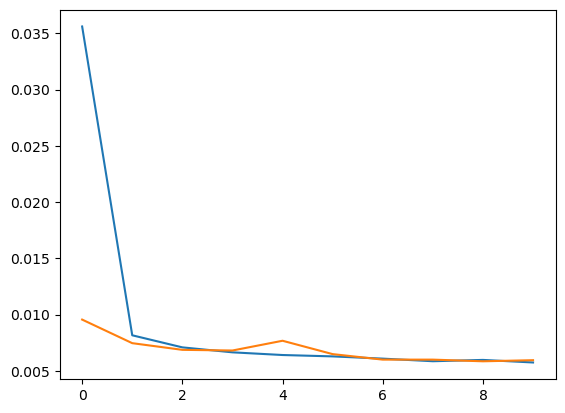

In [80]:
plt.plot(epoch_loss, label='train')
plt.plot(np.array(valid_loss), label='valid')
# plt.plot(epoch_bce_loss, label='train_bce')

In [23]:
model

Convolutional2d_AE(
  (relu): LeakyReLU(negative_slope=0.01)
  (drop_out): Identity()
  (conv_drop_out): Identity()
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Identity()
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Identity()
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): Identity()
    (8): LeakyReLU(negative_slope=0.01)
  )
  (linear_step): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): Identity()
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=1024, out_features=8, bias=True)
    (4): Identity()
    (5): LeakyReLU(negative_slope=0.01)
  )
  (encoder_linear): Linear(in_features=8, out_features=2, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Ident

In [106]:
X_images.shape

(6474, 1, 64, 64)

In [59]:
t_f = t.query("runway_name == '28'")
# t_f = Traffic(t.data.copy())

In [60]:
scaler = fit_scaler(t_f.data[list_features].to_numpy())
X, flight_order = prepare_features(t_f, list_features, scaler)
X = X.reshape(-1, 64, 2).swapaxes(1, 2)


In [61]:
# images = get_images(X, interpolation_precision=2048, image_height=128, gaussian_filter_sigma=0.5)
# images = get_images(X, interpolation_precision=2048, image_height=64, gaussian_filter_sigma=0.5)
images = get_images(X, interpolation_precision=2048, image_height=64, gaussian_filter_sigma=0., max_pixel_value=1)

In [62]:
X_images = images
# Y_images = cae(torch.tensor(X_images, dtype=torch.float32)).detach().numpy()

In [81]:
model.eval()
model.to("cpu")
Y_images = model(torch.tensor(X_images, dtype=torch.float32)).detach().numpy()

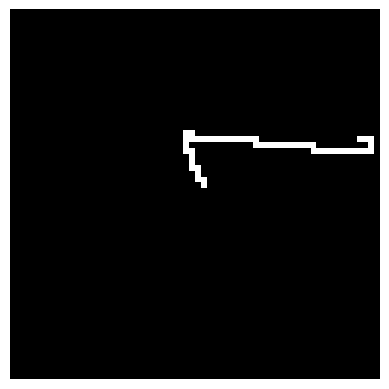

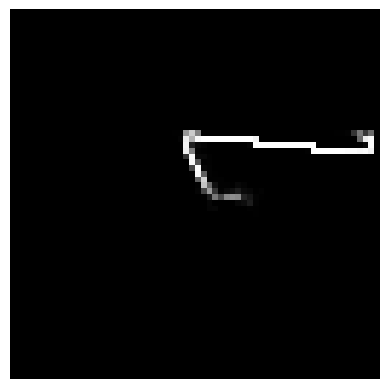

In [85]:
idx = np.random.randint(0, len(X_images))

plt.imshow(X_images[idx].reshape(64, 64), cmap='gray', origin='lower')
plt.axis('off')
plt.show()

plt.imshow(Y_images[idx].reshape(64, 64), cmap='gray', origin='lower')
plt.axis('off')
plt.show()


In [86]:
latent_space = model.latent.detach().cpu().numpy()
latent_space.shape

latent_space_noisy = model.noisy_latent.detach().cpu().numpy()

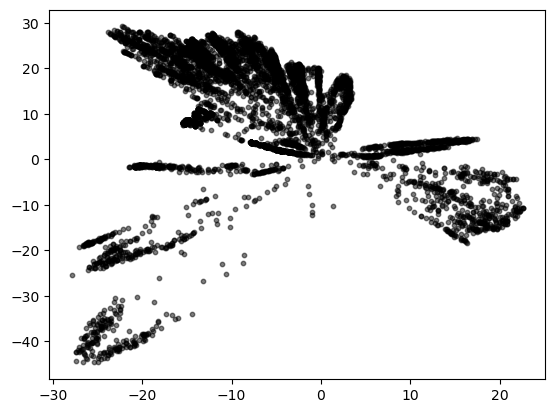

In [87]:
plt.scatter(latent_space[:,0], latent_space[:,1], marker='o', color='black', alpha=0.5, s=10)
plt.show()
# plt.scatter(latent_space_noisy[:,0], latent_space_noisy[:,1], marker='o', color='black', alpha=0.5, s=10)

In [88]:
latent_space = latent_space_noisy

In [167]:
colormap = mpl.colormaps["tab10"]


In [89]:
from sklearn.mixture import GaussianMixture

method = "GaussianMixture"

latent = latent_space
clustering = GaussianMixture(n_components=10).fit(latent)
clusters = clustering.predict(latent)
probs = clustering.predict_proba(latent)
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1124,  471,  579,  280,  507, 1234,  195,  964,  230,  890]))

In [ ]:
from sklearn.cluster import SpectralClustering

method="Spectral Clustering"
latent = latent_space
clustering = SpectralClustering(n_clusters=8, n_jobs=-1).fit(latent)
clusters = clustering.labels_
np.unique(clusters, return_counts=True)


In [624]:
from sklearn.cluster import DBSCAN

method='DBSCAN'
latent = latent_space
clustering = DBSCAN(eps=3, min_samples=50).fit(latent)
clusters = clustering.labels_ + 1
np.unique(clusters, return_counts=True)


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
 array([ 541,  197,  256,  247, 1060, 2829,  189,  491,  486,  178]))

In [536]:
from sklearn.cluster import HDBSCAN

method="HDBSCAN"

latent = latent_space
clustering = HDBSCAN(min_cluster_size=100, max_cluster_size=1000).fit(latent)
clusters = clustering.labels_ + 1
np.unique(clusters, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([2072,  238,  453,  405,  465,  232,  383,  874,  189,  427,  316,
         205,  215]))

In [158]:
from sklearn.cluster import KMeans

method="KMeans"

latent = latent_space
clustering = KMeans(n_clusters=(9)).fit(latent)
clusters = clustering.predict(latent)
np.unique(clusters, return_counts=True)

/opt/homebrew/Caskroom/miniforge/base/envs/artefact/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([ 597,  195,  647,  271,  958, 1738,  424, 1390,  254]))

9

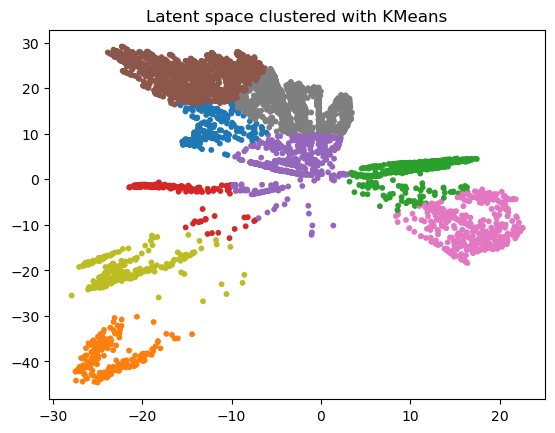

In [168]:
plt.scatter(latent[:, 0], latent[:, 1], c=[colormap(c) for c in clusters], s=10)
# plt.colorbar()
plt.title(f"Latent space clustered with {method}")
len(np.unique(clusters))


In [167]:
len(clusters)

6474

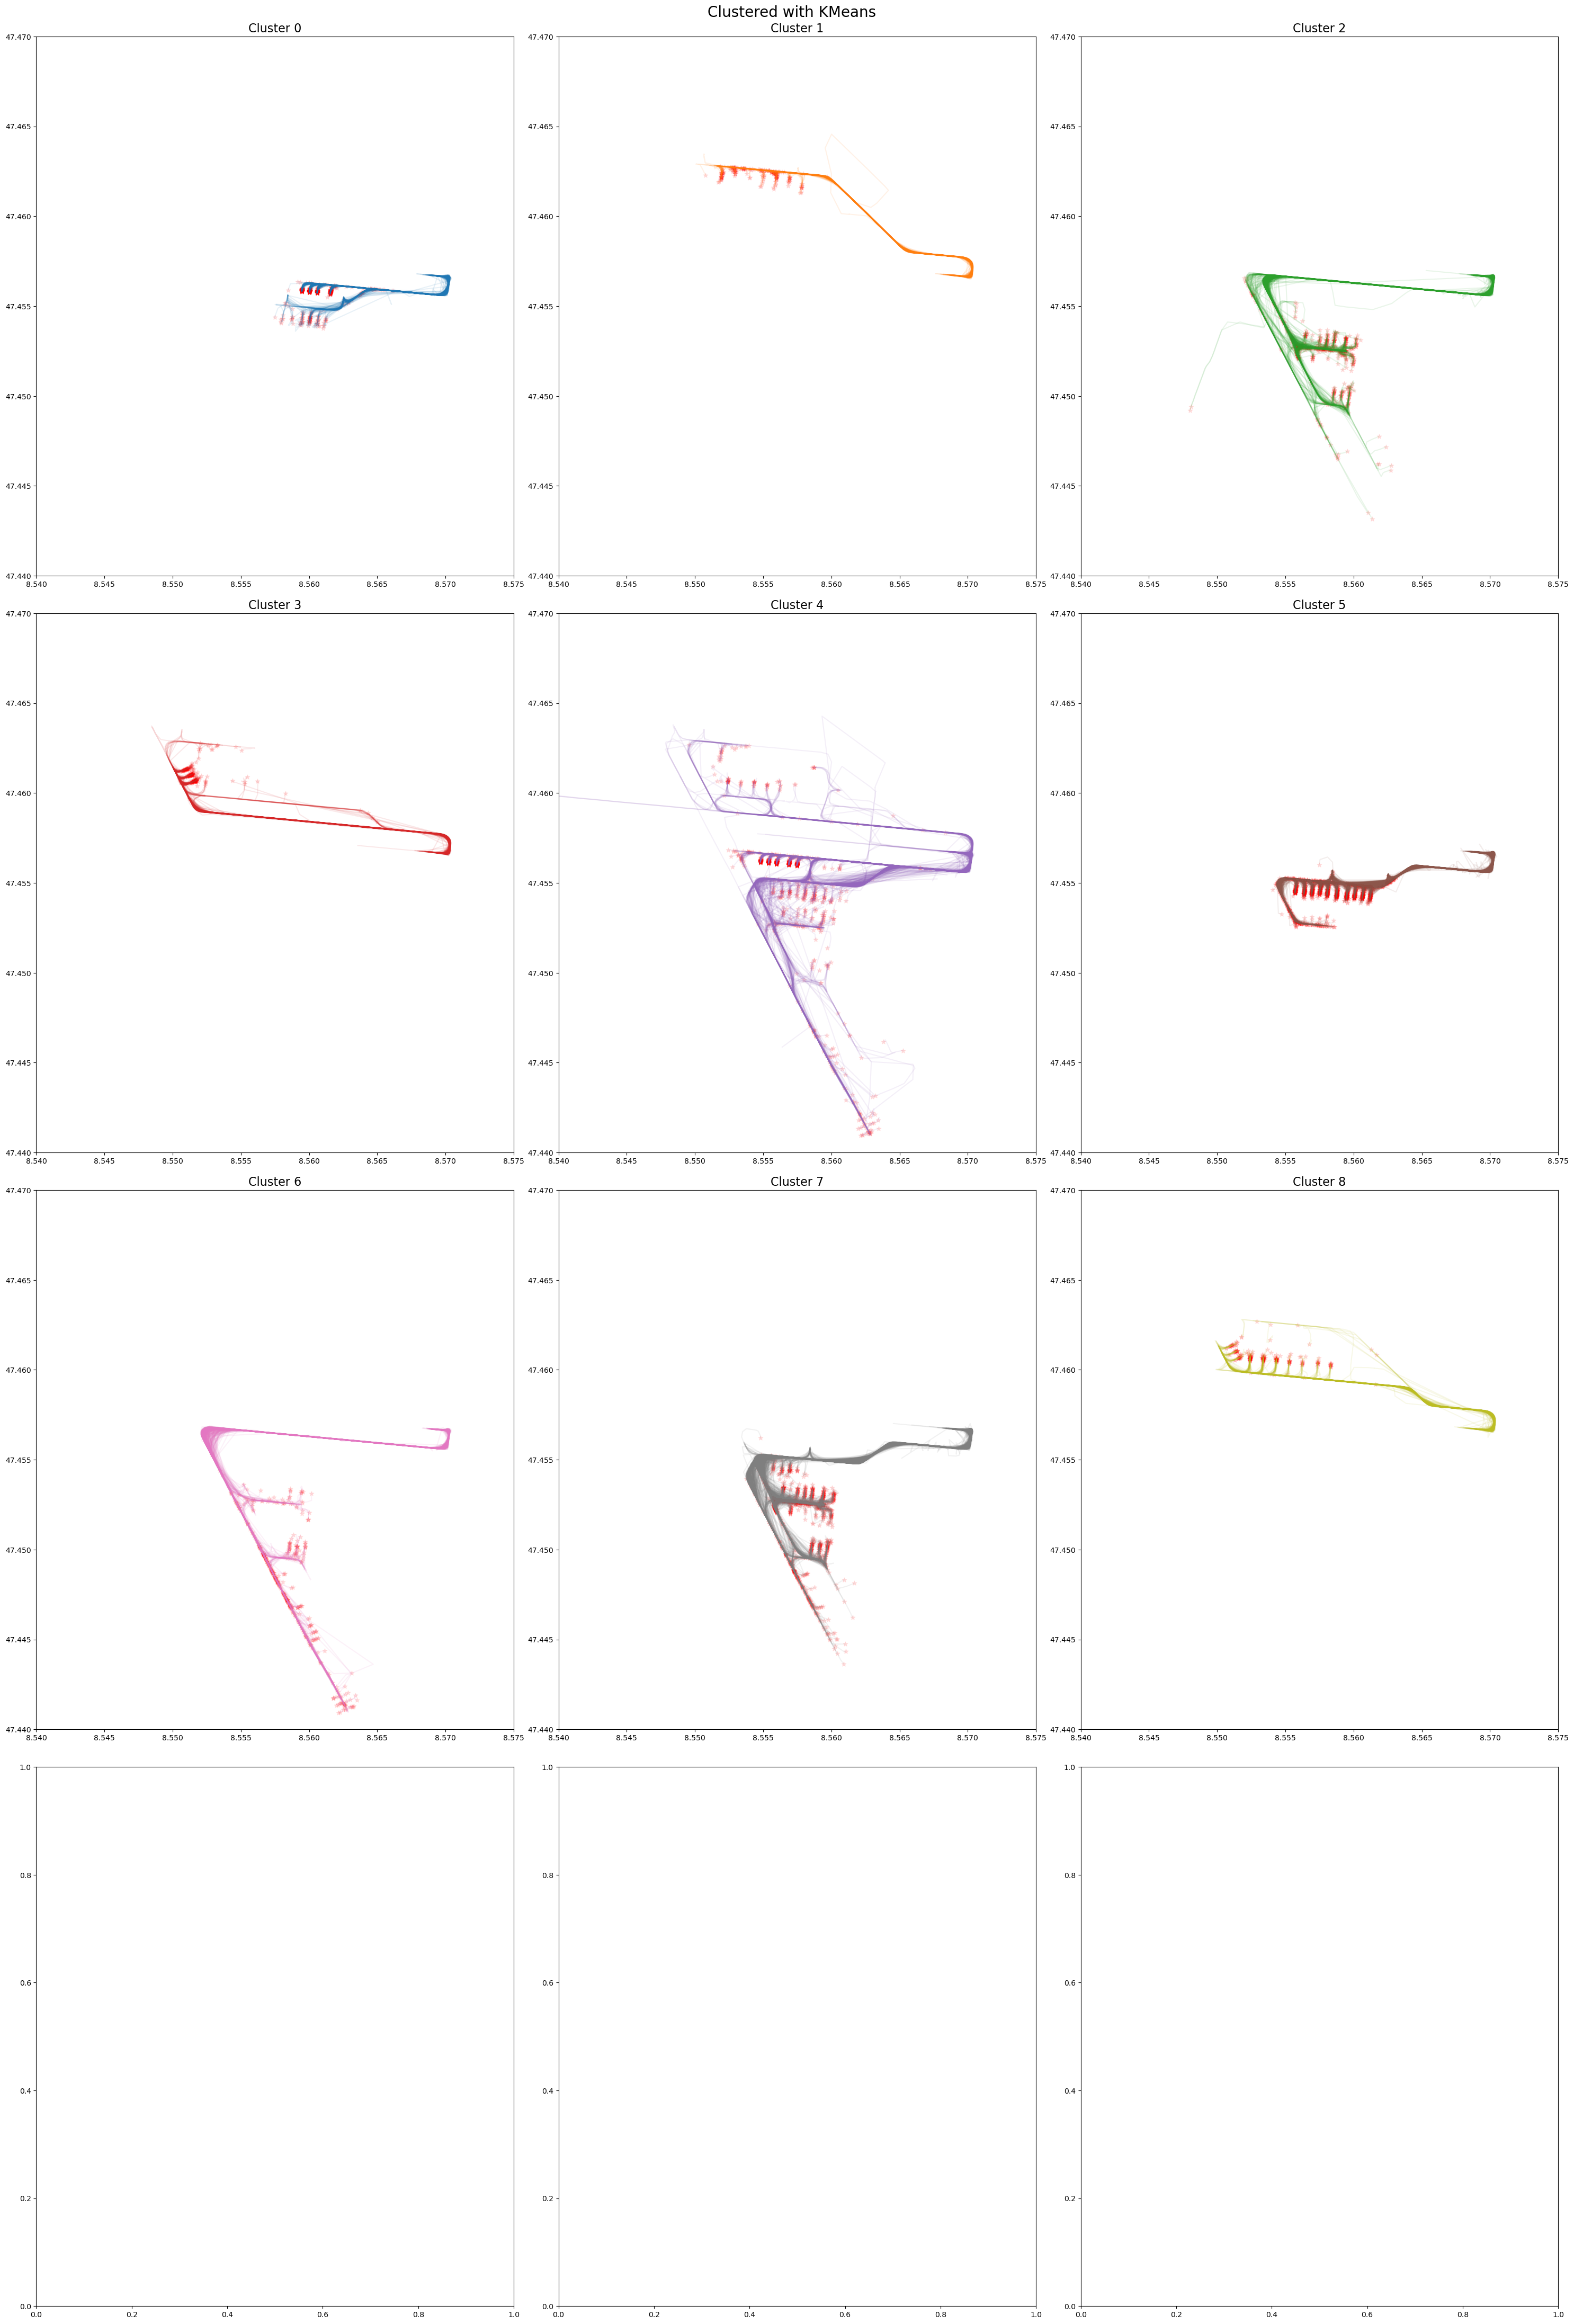

In [169]:
figsize = (3, 4)


fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 45))
fig.suptitle(f"Clustered with {method}\n", fontsize=20)
fig.tight_layout(pad=3.0)

order = np.array(flight_order)

for cluster in np.unique(clusters):
    cluster_mask = clusters == cluster
    flights = t_f[order[cluster_mask]]

    with plt.style.context("traffic"):
        ax = axs[cluster // 3, cluster % 3]

        for flight in flights:
            flight.plot(ax=ax, alpha=0.1, color=colormap(cluster))
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.1,
            )

        ax.set_title(f"Cluster {cluster}")
        ax.set_xlim(8.54, 8.575)
        ax.set_ylim(47.44, 47.47)

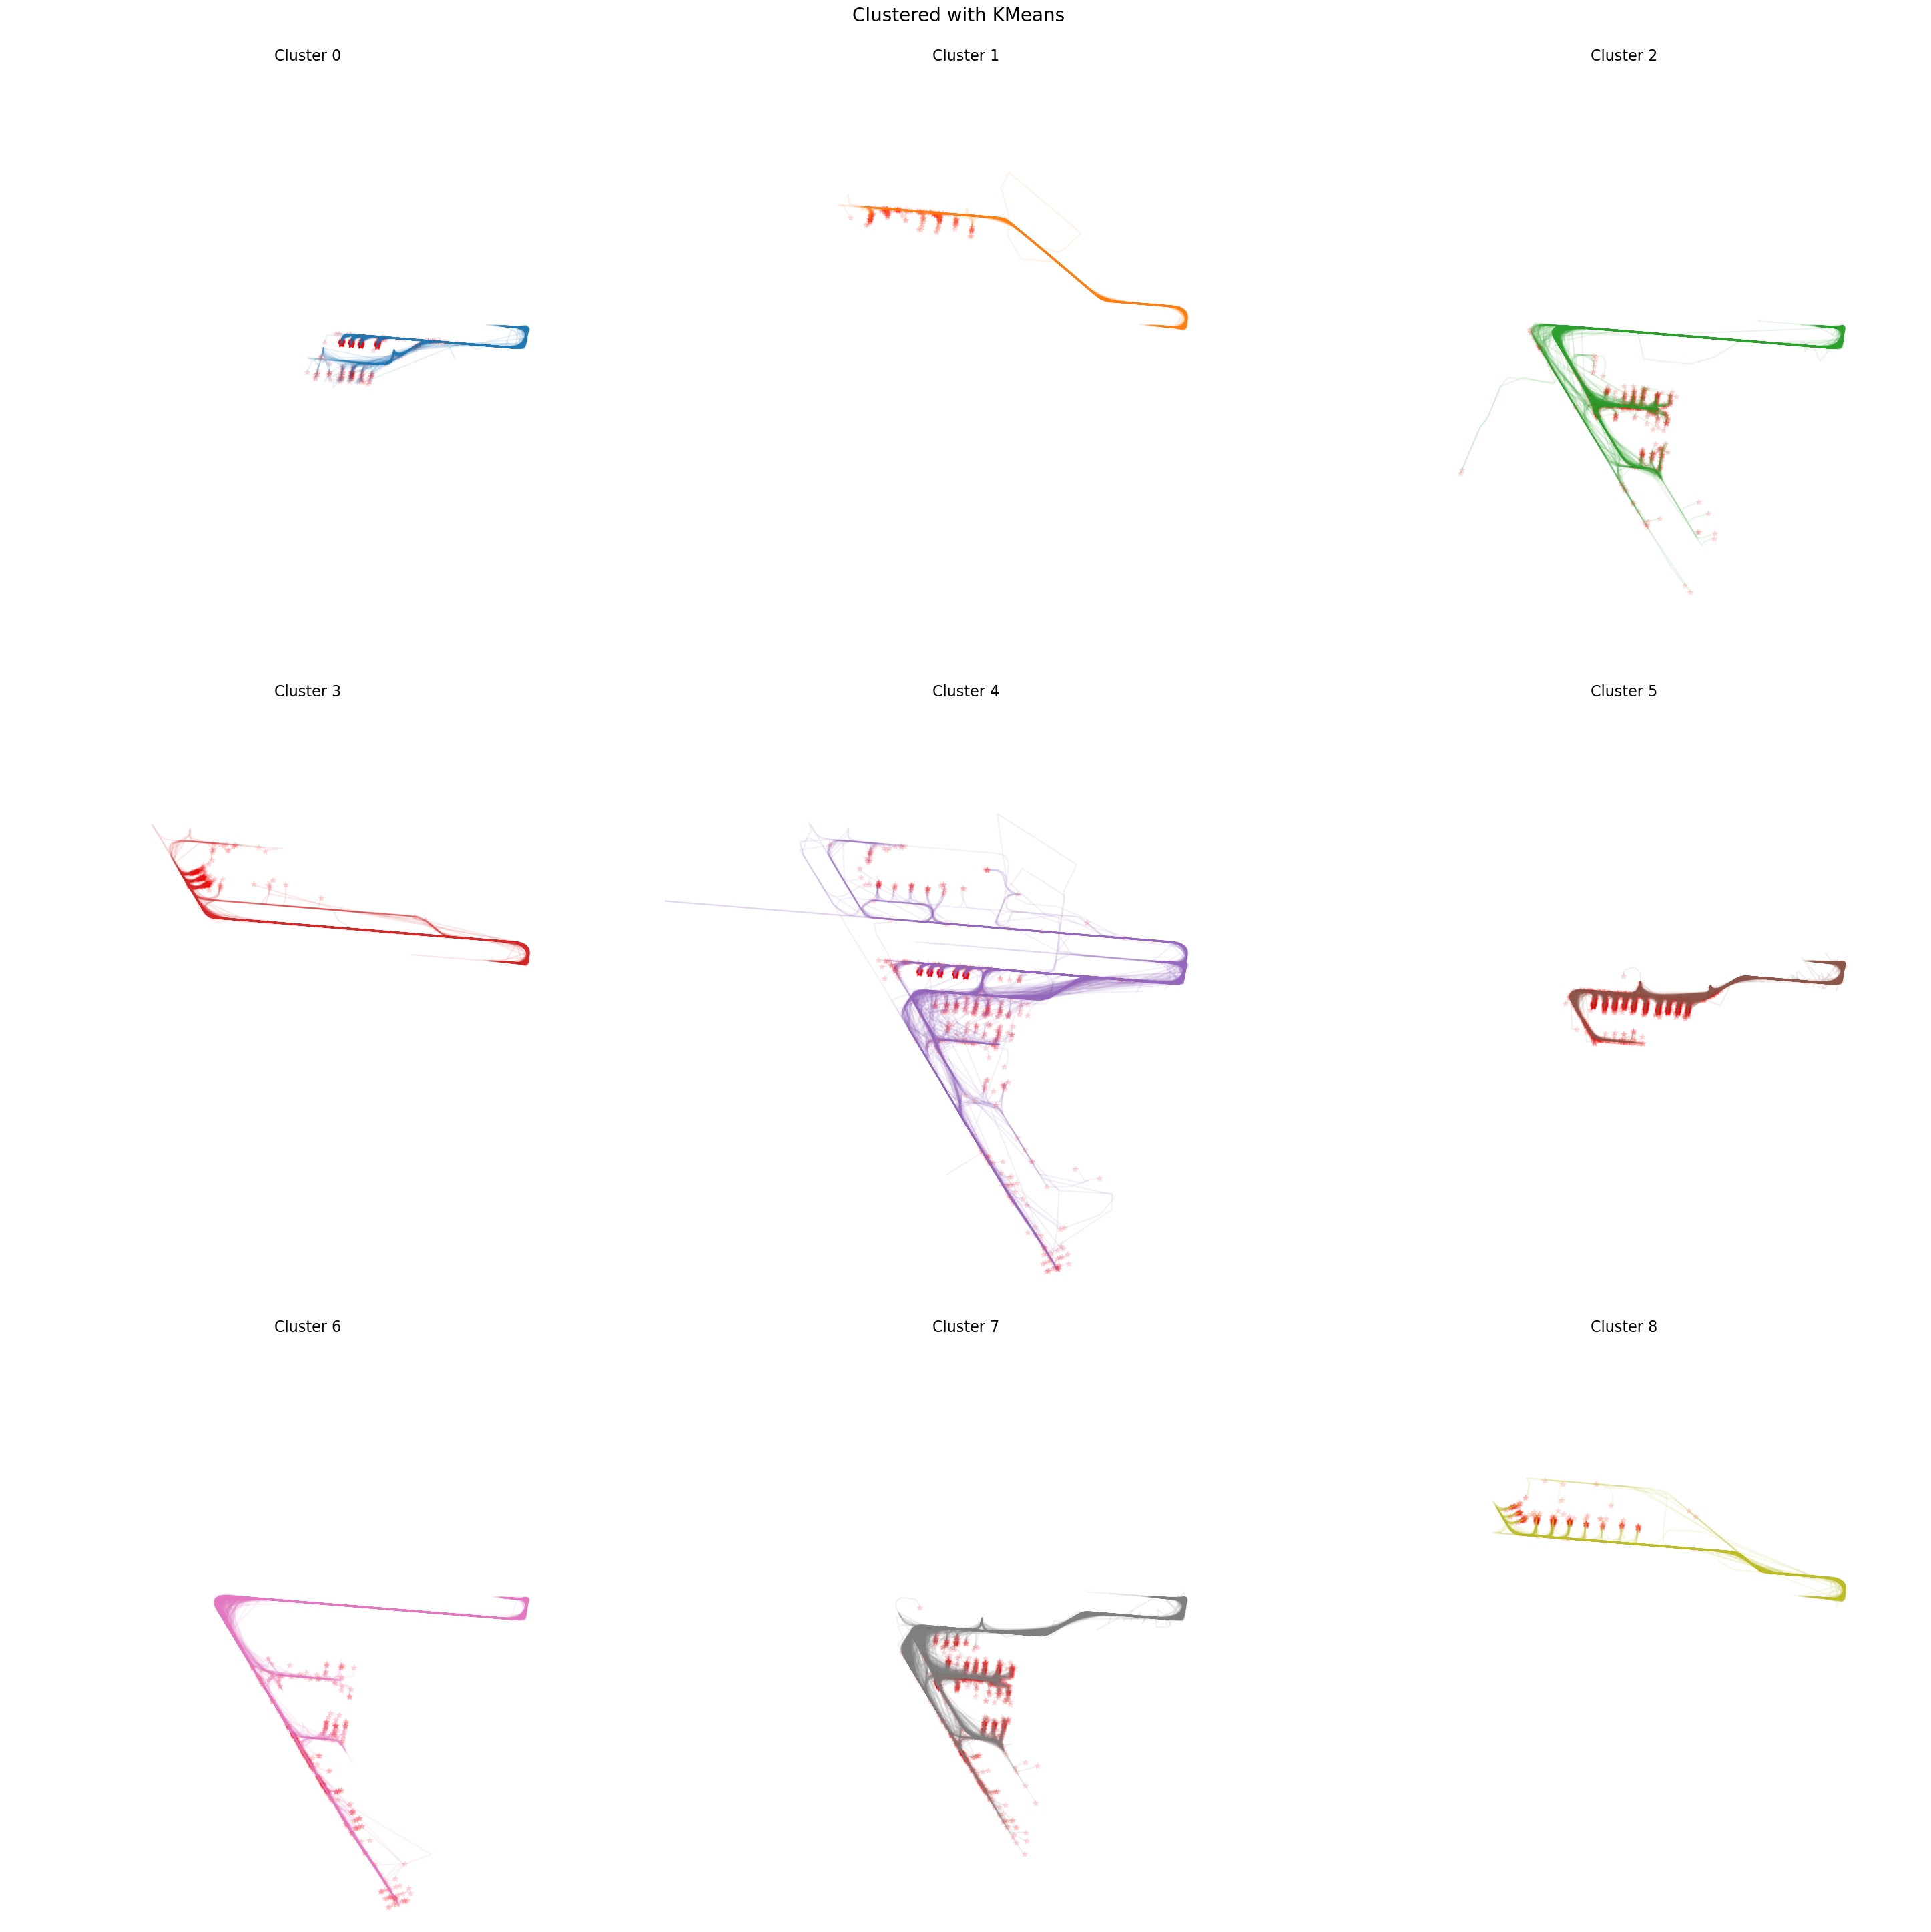

In [170]:
figsize = (3, 4)


fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(30, 30))
fig.suptitle(f"Clustered with {method}\n", fontsize=20)
fig.tight_layout(pad=3.0)

order = np.array(flight_order)

for cluster in np.unique(clusters):
    cluster_mask = clusters == cluster
    flights = t_f[order[cluster_mask]]

    with plt.style.context("traffic"):
        ax = axs[cluster // 3, cluster % 3]

        for flight in flights:
            flight.plot(ax=ax, alpha=0.1, color=colormap(cluster))
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.1,
            )

        ax.set_title(f"Cluster {cluster}")
        ax.set_xlim(8.54, 8.575)
        ax.set_ylim(47.44, 47.47)

        ax.axis('off')

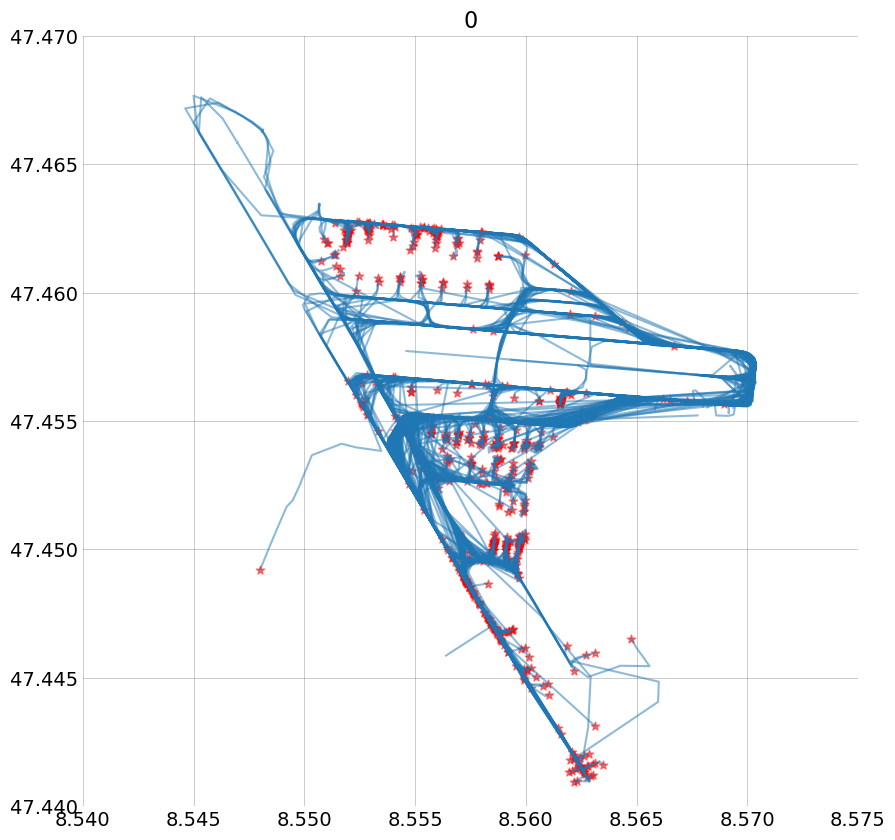

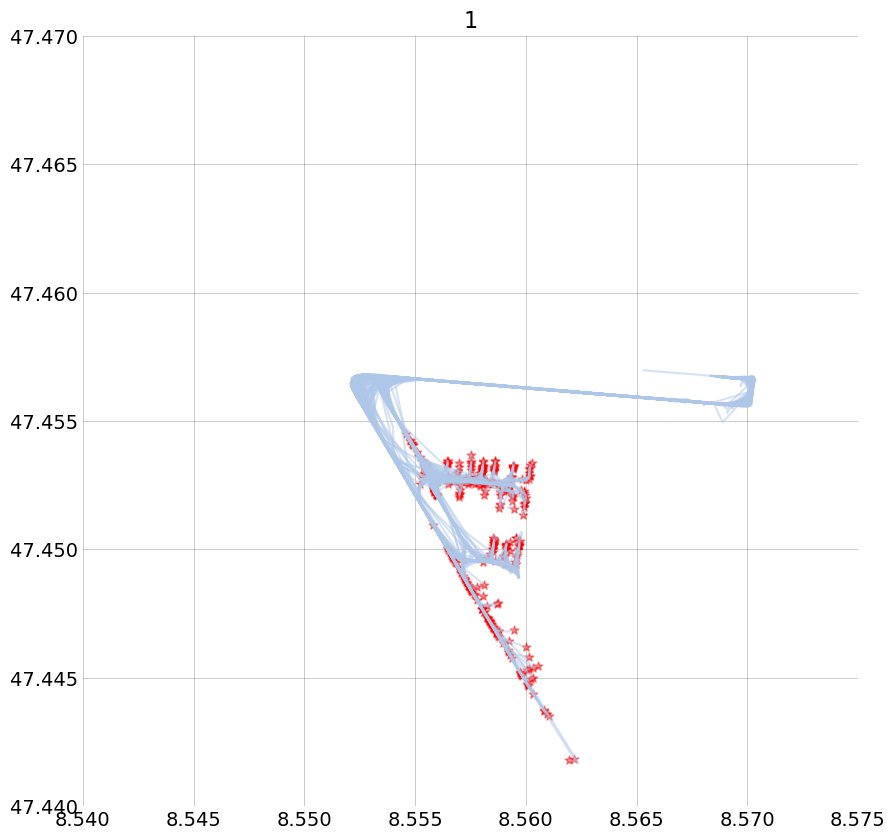

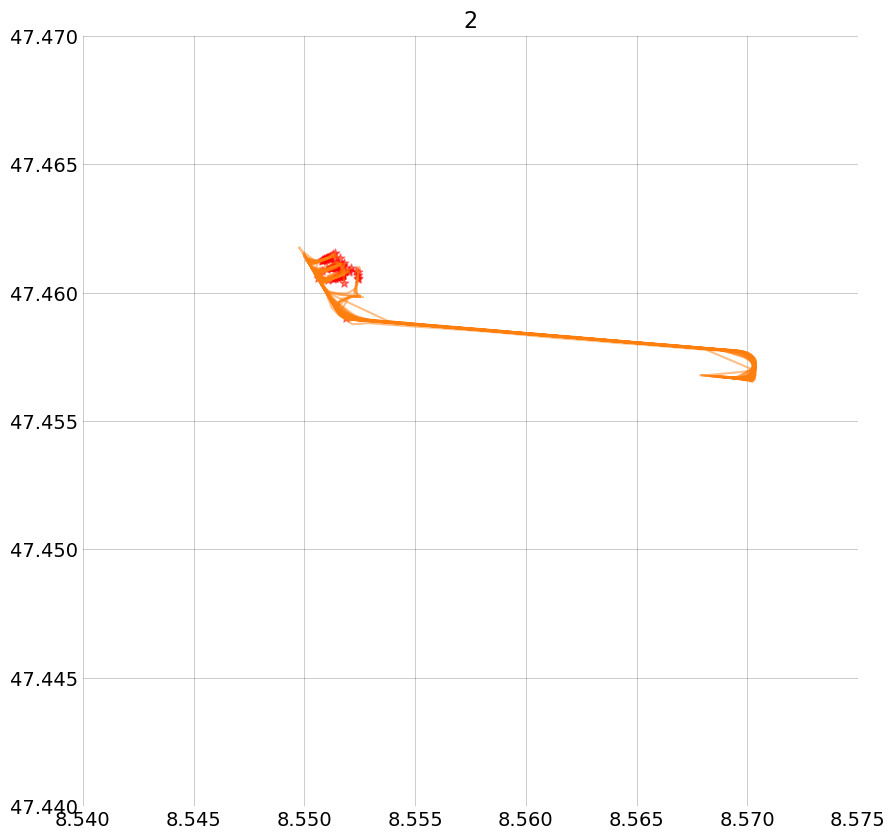

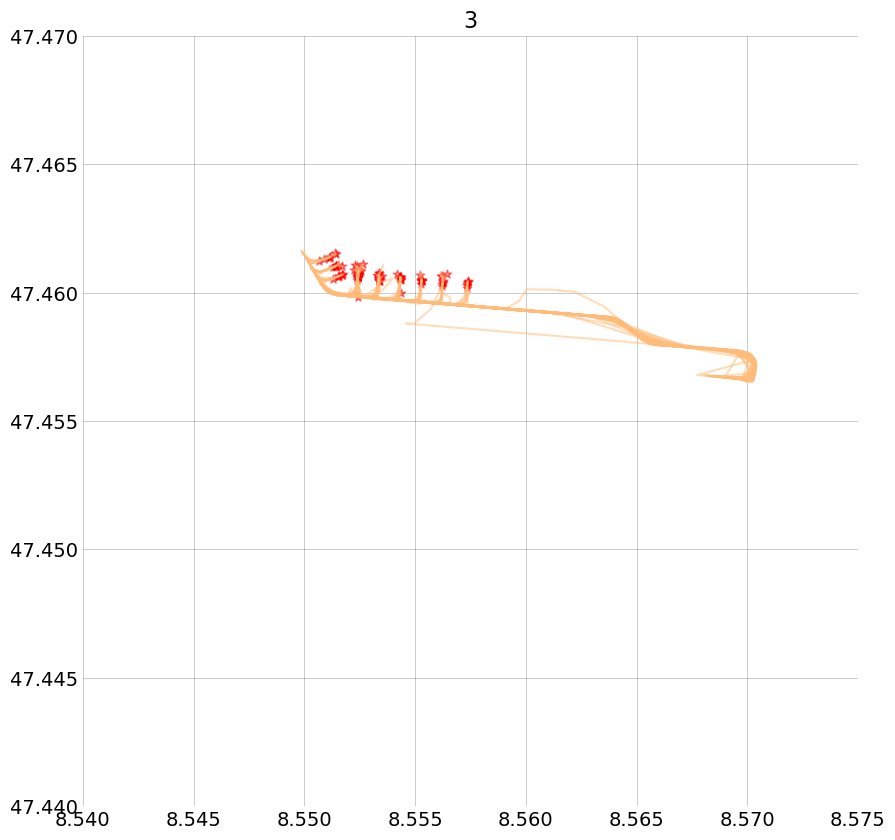

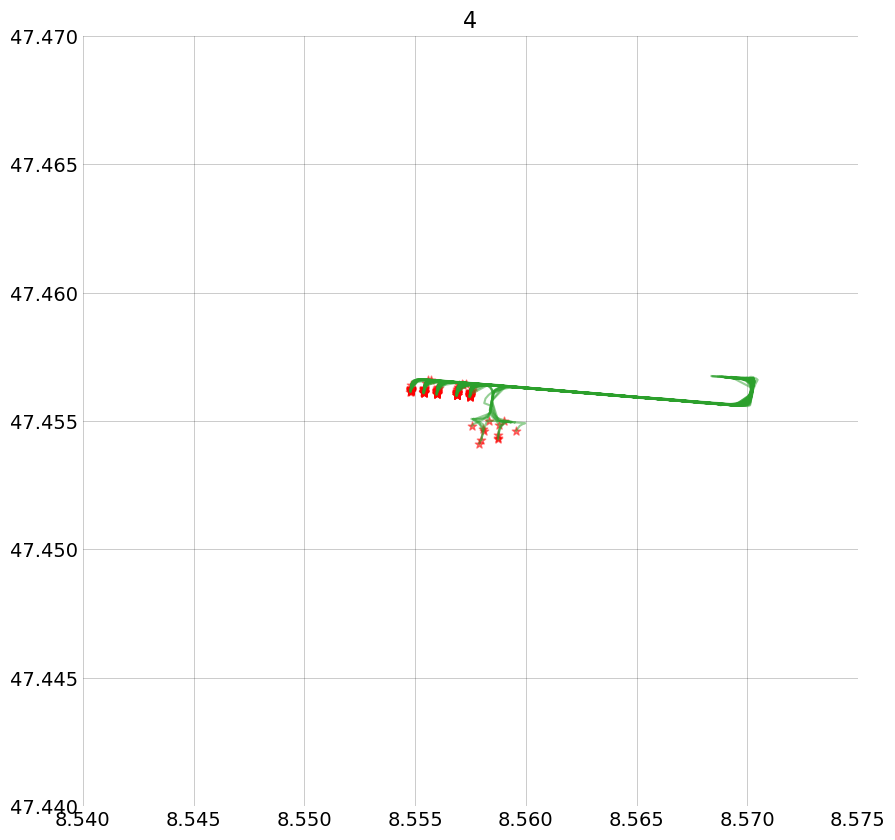

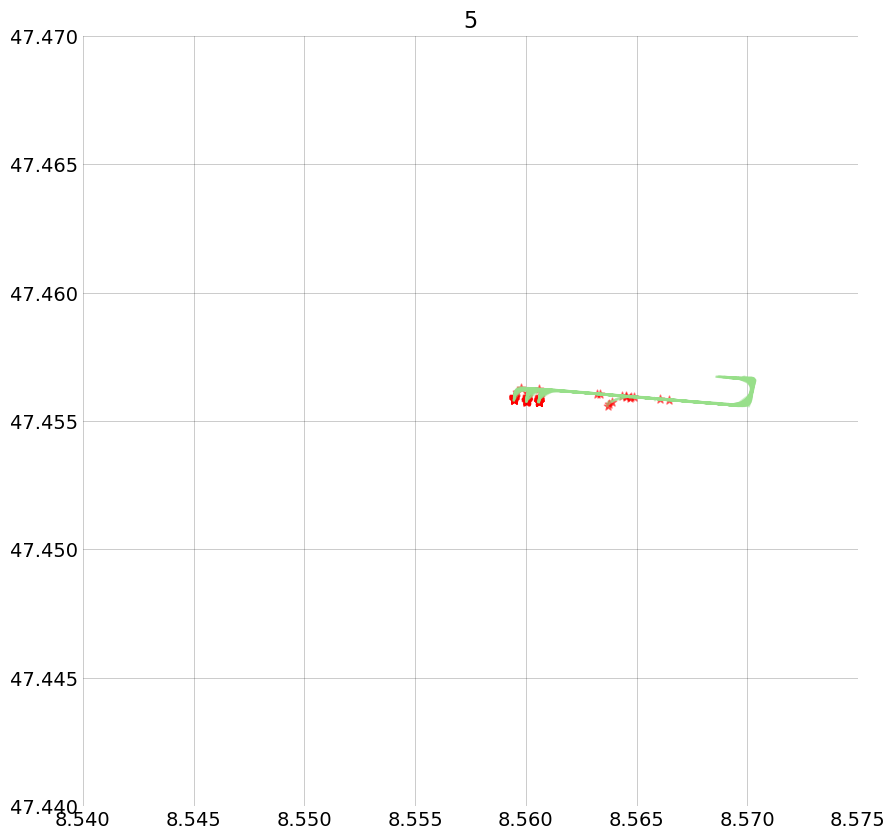

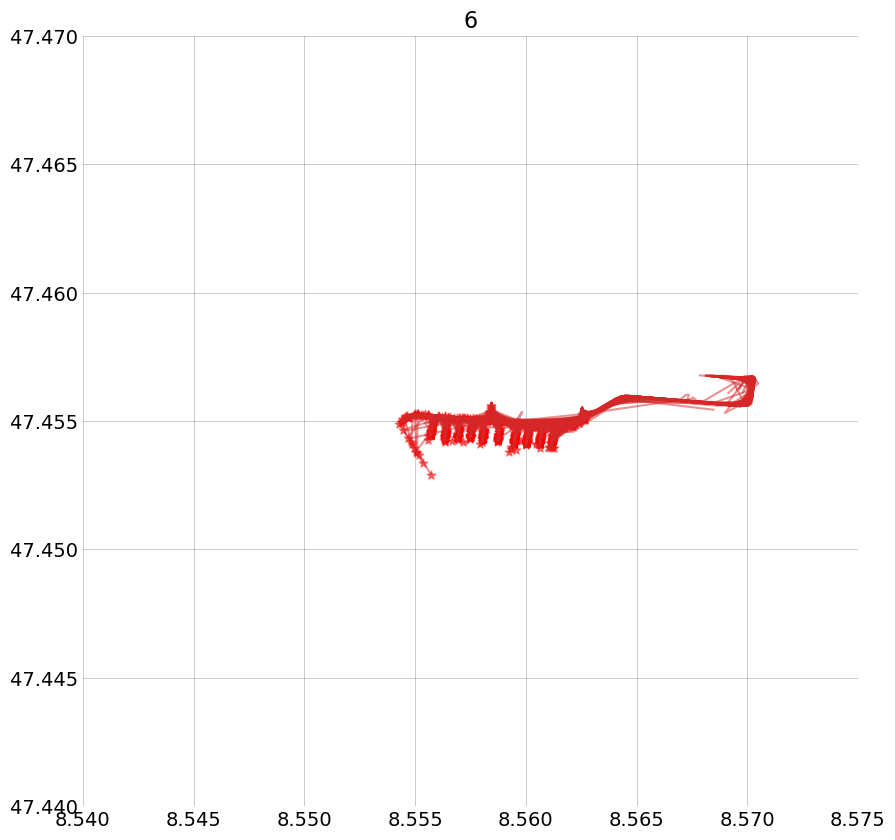

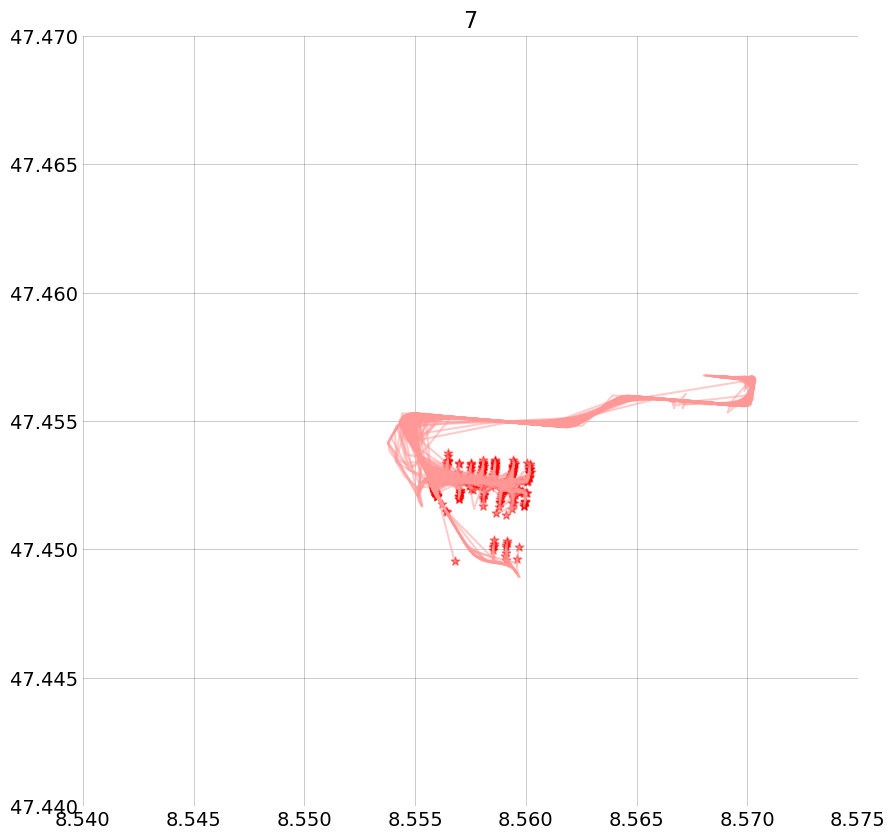

In [675]:
for cluster_ in np.unique(clusters):
    with plt.style.context("traffic"):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(cluster_)

        for cluster, flight_id in zip(clusters, flight_order):
            if cluster != cluster_:
                continue
            flight = t_f[flight_id]
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.5,
            )
            flight.plot(ax=ax, alpha=0.5, color=colormap(cluster))
            ax.set_xlim(8.54, 8.575)
            ax.set_ylim(47.44, 47.47)
        
        plt.show()

In [100]:
flight_order.__len__()

6474

In [135]:
for flight in t_f: 
    if not flight.data.timestamp.is_monotonic_increasing:
        print("miche")

In [171]:
taxi_durations = {flight_id: 0 for flight_id in flight_order}

for flight in t_f:
    taxi_durations[flight.flight_id] = (flight.data.timestamp.iloc[-1] - flight.data.timestamp.iloc[0]).total_seconds()

    

In [137]:
taxi_durations

{'AAL93_19187': 913.0,
 'AAL93_19194': 818.0,
 'AAL93_19207': 633.0,
 'AAL93_19210': 709.0,
 'AAL93_19224': 618.0,
 'AAL93_19227': 779.0,
 'AAL93_19241': 667.0,
 'AAL93_19244': 692.0,
 'AAL93_19247': 849.0,
 'AAL93_19249': 565.0,
 'AAL93_19251': 820.0,
 'AAL93_19259': 722.0,
 'AAL93_19262': 1057.0,
 'AAL93_19271': 968.0,
 'AAL93_19383': 599.0,
 'AAL93_19387': 458.0,
 'ABN4006_17167': 1647.0,
 'ABN4006_17169': 840.0,
 'ABN4006_17172': 1909.0,
 'ABN4006_17175': 453.0,
 'ACA881_19476': 581.0,
 'ACA881_19523': 783.0,
 'ACA881_19528': 647.0,
 'ACA883_19551': 648.0,
 'ACA883_19565': 919.0,
 'ACA883_19609': 643.0,
 'ACA883_19615': 537.0,
 'AEA70VW_344': 715.0,
 'AEA70VW_346': 644.0,
 'AEA70VW_352': 562.0,
 'AEA70VW_354': 400.0,
 'AEA70VW_380': 432.0,
 'AEA70VW_381': 452.0,
 'AEA70VW_457': 478.0,
 'AEA70VW_458': 522.0,
 'AEA70VW_459': 159.0,
 'AEA70VW_460': 655.0,
 'AEA70VW_461': 812.0,
 'AEA70VW_464': 482.0,
 'AEA70VW_465': 504.0,
 'AEA70VW_480': 506.0,
 'AEA70VW_481': 623.0,
 'AEA70VW_482': 

In [172]:
infos_taxi = pd.DataFrame(zip(list(taxi_durations.keys()), list(taxi_durations.values())), index=pd.RangeIndex(0, len(taxi_durations)), columns=['flight_id', 'taxi_duration'])
infos_taxi

,flight_id,taxi_duration
0,AAL93_19187,913.0
1,AAL93_19194,818.0
2,AAL93_19207,633.0
3,AAL93_19210,709.0
4,AAL93_19224,618.0
...,...,...
6469,VLG94GN_436,523.0
6470,VLG94GN_512,201.0
6471,VLG94GN_517,472.0
6472,VLG94GN_617,438.0


In [173]:
infos_taxi["cluster"] = infos_taxi["flight_id"].apply(lambda x: clusters[flight_order.index(x)])

In [174]:
infos_taxi["taxi_duration_min"] = infos_taxi["taxi_duration"] / 60

In [165]:
infos_taxi

,flight_id,taxi_duration,cluster,taxi_duration_min
0,AAL93_19187,913.0,1,15.216667
1,AAL93_19194,818.0,1,13.633333
2,AAL93_19207,633.0,1,10.550000
3,AAL93_19210,709.0,1,11.816667
4,AAL93_19224,618.0,1,10.300000
...,...,...,...,...
6469,VLG94GN_436,523.0,5,8.716667
6470,VLG94GN_512,201.0,5,3.350000
6471,VLG94GN_517,472.0,5,7.866667
6472,VLG94GN_617,438.0,5,7.300000


In [120]:
import seaborn as sns

(0.0, 20.0)

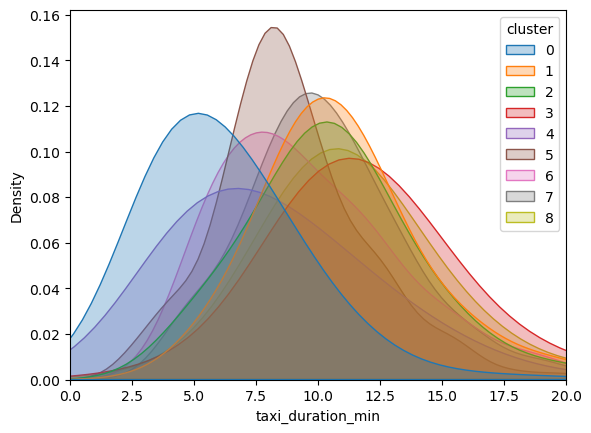

In [175]:
sns.kdeplot(
    data=infos_taxi,
    x="taxi_duration_min",
    hue="cluster",
    palette="tab10",
    fill=True,
    alpha=0.3,
    linewidth=1,
    common_norm=False,
)

plt.xlim(0, 20)

(0.0, 20.0)

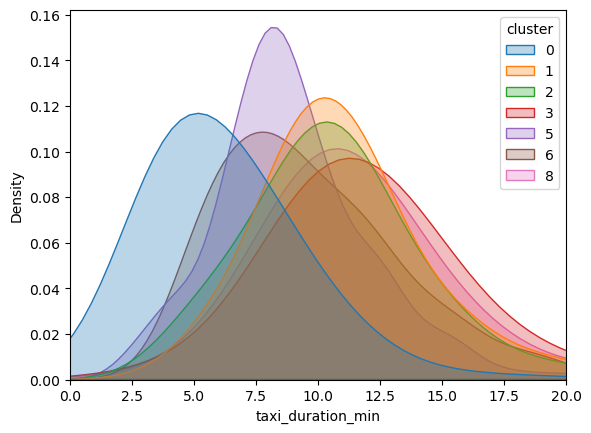

In [177]:
sns.kdeplot(
    data=infos_taxi.query("cluster in [0, 1, 2, 3, 5, 6, 8]"),
    x="taxi_duration_min",
    hue="cluster",
    palette="tab10",
    fill=True,
    alpha=0.3,
    linewidth=1,
    common_norm=False,
)

plt.xlim(0, 20)

/var/folders/6r/vdmz5zjj6_d8769grj_ht__80000gn/T/ipykernel_25343/3736655144.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legend


(0.0, 20.0)

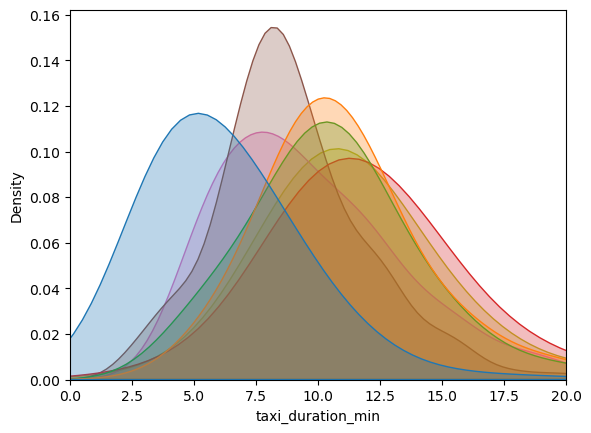

In [188]:
infos_taxi_ = infos_taxi.copy()
# infos_taxi_[infos_taxi_["cluster"] == 4].loc["taxi_duration_min"] = -100
# infos_taxi_[infos_taxi_["cluster"] == 7].loc["taxi_duration_min"] = -100
infos_taxi_.loc[infos_taxi_["cluster"] == 4, "taxi_duration_min"] = -100
infos_taxi_.loc[infos_taxi_["cluster"] == 7, "taxi_duration_min"] = -100

sns.kdeplot(
    data=infos_taxi_,
    x="taxi_duration_min",
    hue="cluster",
    palette="tab10",
    fill=True,
    alpha=0.3,
    linewidth=1,
    common_norm=False,
)

# print(plt.legend())

plt.legend([],[], frameon=False)

plt.xlim(0, 20)